In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')
c_multi_gamma_prob_v1d_x = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)
c_multi_gamma_sf_v1d_x = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

In [40]:


dist = 20
z = -500
rho = 0.0
zenith = 1.57
azimuth = 3.9264083

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)



In [41]:
xvals = np.linspace(-20, 100, 1000)
probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.1)

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


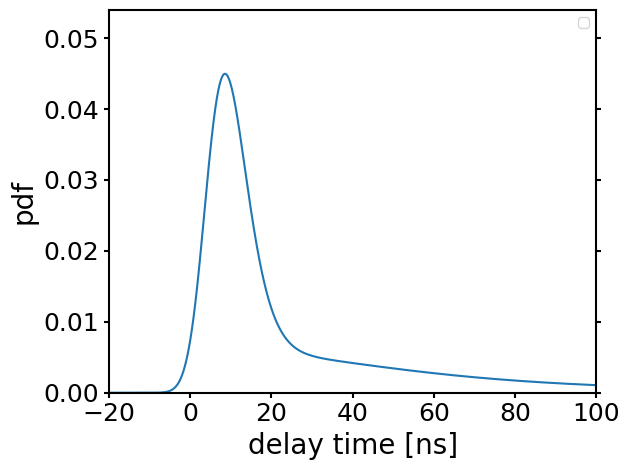

In [42]:
fig, ax = plt.subplots()
plt.plot(xvals, probs)
plot_args = {'xlim':[-20, 100],
                     'ylim':[0.0, 1.2 * np.amax(probs)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

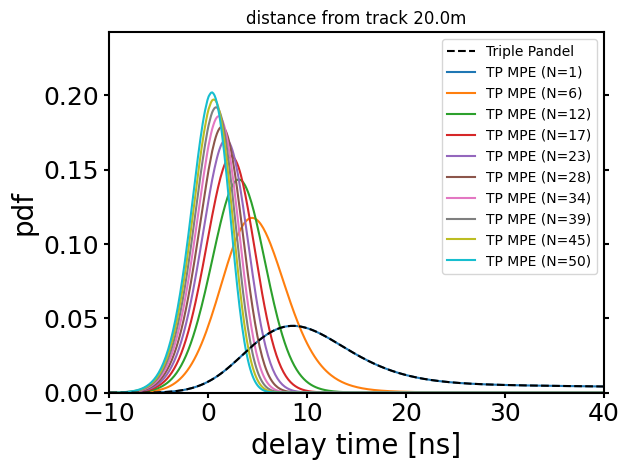

In [43]:
probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0)

fig, ax = plt.subplots()
plt.plot(xvals, probs,linestyle='dashed', color='black', zorder=100, label='Triple Pandel')

y_max = np.amax(probs)
n_photons = jnp.array(np.linspace(1, 50, 10))
for n_p in n_photons:
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})')
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 40],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [44]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions



@jax.jit
def convolved_mpe(x, logits, gamma_a, gamma_b, n_photons, sigma):
    
    gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=gamma_a,
                    rate=gamma_b,
                    force_probs_to_zero_outside_support=True
                      )
                )

    gn = tfp.distributions.Normal(
                x,
                sigma,
                validate_args=False,
                allow_nan_stats=False,
                name='Normal'
            )


    xmax = jnp.max(jnp.array([jnp.array(5 * sigma), x + 5 * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    #xmin = x - diff
    xvals = jnp.linspace(xmin, xmax, 41)
    xvals = 0.5 * (xvals[1:]+xvals[:-1])
    dx = xvals[1] - xvals[0]
    
    probs_mpe = n_photons * gm.prob(xvals) * jnp.power(gm.survival_function(xvals), n_photons-1)
    probs_norm = gn.prob(xvals)

    return jnp.sum(probs_mpe * probs_norm) * dx
    
convolved_mpe_v1d_x = jax.jit(jax.vmap(convolved_mpe, (0, None, None, None, None, None), 0))

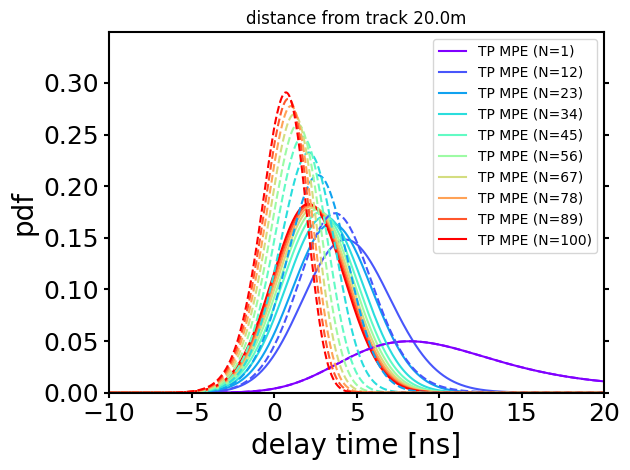

In [45]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0 
n_photons = jnp.array(np.linspace(1, 100, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_v1d_x(xvals, logits, gamma_a, gamma_b, n_p, 2.0)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 2.0, 0.1)
sfs = c_multi_gamma_sf_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 2.0)

for i, n_p in enumerate(n_photons):
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, linestyle='dashed', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [46]:
@jax.jit
def convolved_mpe_single_gamma(x, gamma_a, gamma_b, n_photons, sigma):
    g_pdf = tfd.Gamma(concentration=gamma_a, 
                  rate=gamma_b, 
                  force_probs_to_zero_outside_support=True)

    gn = tfp.distributions.Normal(
                x,
                sigma,
                validate_args=False,
                allow_nan_stats=False,
                name='Normal'
            )

    nmax = 20
    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    xvals = jnp.linspace(xmin, xmax, 41)

    n_pdf = gn.prob(0.5*(xvals[:-1]+xvals[1:]))
    sfs_power_n = jnp.power(g_pdf.survival_function(xvals), n_photons)

    return jnp.sum( n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]) )

convolved_mpe_single_gamma_v1d_x = jax.jit(jax.vmap(convolved_mpe_single_gamma, (0, None, None, None, None), 0))

In [47]:
a = gamma_a[0]
b = gamma_b[0]

print(convolved_mpe_single_gamma(0.9, a, b, 1.0, 2.0))

0.0038082439157225254


/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


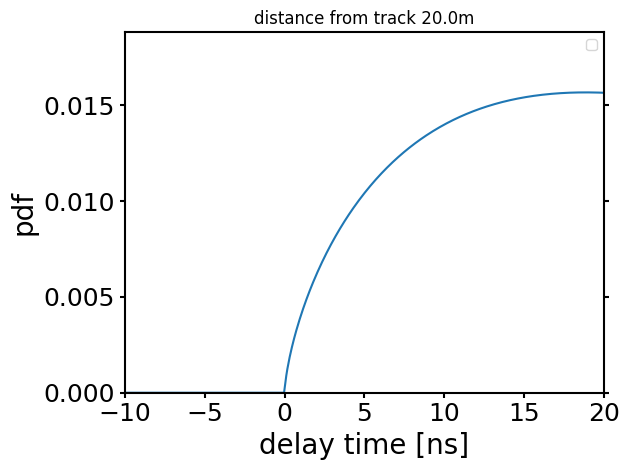

In [48]:
a = gamma_a[0]
b = gamma_b[0]
g = tfd.Gamma(concentration=a, rate=b, force_probs_to_zero_outside_support=True)

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

yvals = g.prob(xvals)
y_max = np.amax(yvals)

plt.plot(xvals, yvals)
plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

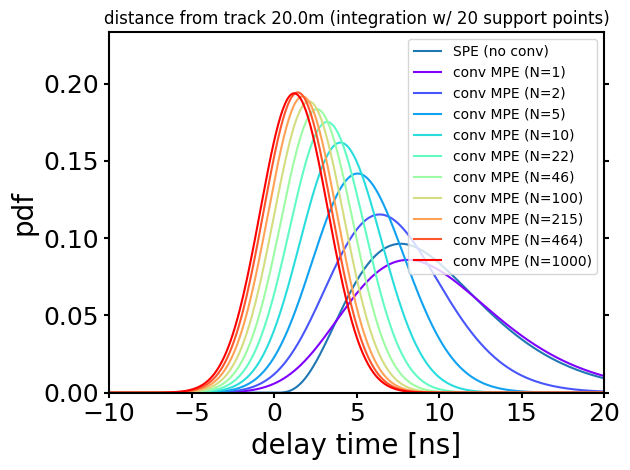

In [49]:
a = gamma_a[1]
b = gamma_b[1]
g = tfd.Gamma(concentration=a, rate=b, force_probs_to_zero_outside_support=True)

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

yvals = g.prob(xvals)
y_max = np.amax(yvals)
plt.plot(xvals, yvals, label='SPE (no conv)')

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_single_gamma_v1d_x(xvals, a, b, n_p, 2.0)
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.show()

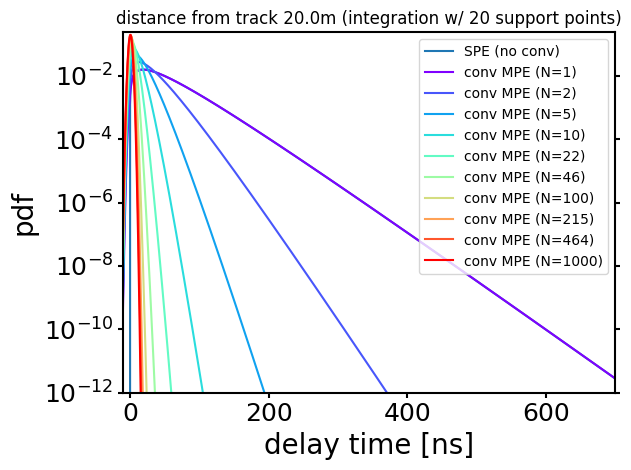

In [50]:
a = gamma_a[0]
b = gamma_b[0]
g = tfd.Gamma(concentration=a, rate=b, force_probs_to_zero_outside_support=True)

fig, ax = plt.subplots()
xvals = np.linspace(-20, 700, 1000)

yvals = g.prob(xvals)
y_max = np.amax(yvals)
plt.plot(xvals, yvals, label='SPE (no conv)')

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_single_gamma_v1d_x(xvals, a, b, n_p, 2.0)
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 700],
                     'ylim':[1.e-12, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_yscale('log')
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.show()

In [51]:
def convolved_mpe_single_gamma_dima(x, gamma_a, gamma_b, n_photons, sigma):
    g_pdf = tfd.Gamma(concentration=gamma_a, 
                  rate=gamma_b, 
                  force_probs_to_zero_outside_support=True)

    gn = tfp.distributions.Normal(
                x,
                sigma,
                validate_args=False,
                allow_nan_stats=False,
                name='Normal'
            )

    xmax = x + 5 * sigma
    xmin = x - 5 * sigma
    xvals = jnp.linspace(xmin, xmax, 21)

    n_pdf = gn.prob(0.5*(xvals[:-1]+xvals[1:]))
    sfs_power_n = jnp.power(g_pdf.survival_function(xvals), n_photons)

    return jnp.sum( n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]) )

convolved_mpe_single_gamma_dima_v1d_x = jax.jit(jax.vmap(convolved_mpe_single_gamma_dima, (0, None, None, None, None), 0))

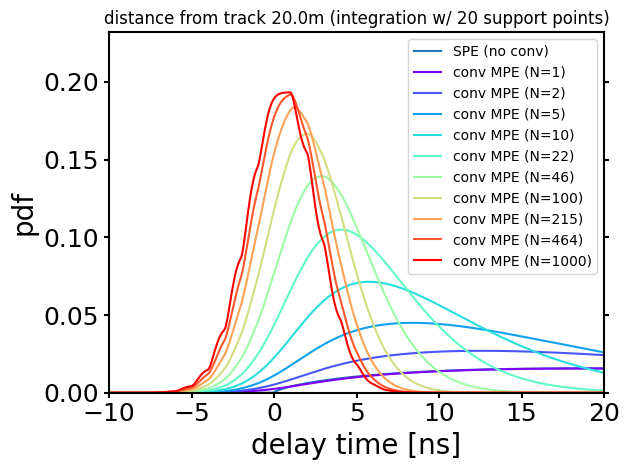

In [52]:
a = gamma_a[0]
b = gamma_b[0]
g = tfd.Gamma(concentration=a, rate=b, force_probs_to_zero_outside_support=True)

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

yvals = g.prob(xvals)
y_max = np.amax(yvals)
plt.plot(xvals, yvals, label='SPE (no conv)')

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_single_gamma_dima_v1d_x(xvals, a, b, n_p, 2.0)
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.show()

In [53]:
from scipy.integrate import quad

In [54]:
f = lambda x: convolved_mpe_single_gamma(x, gamma_a[0], gamma_b[0], 1000.0, 2.0)
quad(f, -30, 100)

(1.0034111201292875, 1.2752521945937085e-08)

In [55]:
def c_multi_gamma_mpe_prob(x, logits, a, b, n, sigma, nmax=20, nint=41):
    g_pdf = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=a,
                    rate=b,
                    force_probs_to_zero_outside_support=True
                      )
                )
    gn = tfp.distributions.Normal(
                x,
                sigma,
                validate_args=False,
                allow_nan_stats=False,
                name='Normal'
            )

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    xvals = jnp.linspace(xmin, xmax, nint)

    n_pdf = gn.prob(0.5*(xvals[:-1]+xvals[1:]))
    sfs_power_n = jnp.power(g_pdf.survival_function(xvals), n)

    return jnp.sum( n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]) )

c_multi_gamma_mpe_prob_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob, (0, None, None, None, None, None), 0))

In [56]:
n_p = 100.0
print(c_multi_gamma_mpe_prob(0.0, logits, gamma_a, gamma_b, n_p, 2.0))

0.11560456066389335


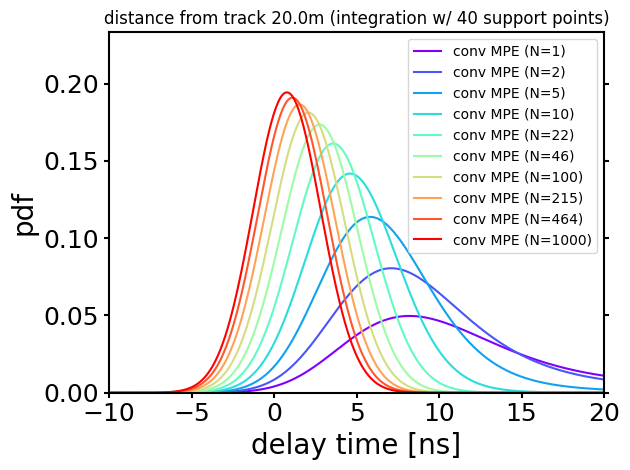

In [58]:
fig, ax = plt.subplots()
xvals = jnp.linspace(-20, 50, 1000)

y_max = 0 
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = c_multi_gamma_mpe_prob_v1d_x(xvals, logits, gamma_a, gamma_b, n_p, 2.0)
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])


plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 40 support points)")
plt.tight_layout()
plt.show()